In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

# from pts.modules import StudentTOutput

from ConvTSMixer import ConvTSMixerEstimator

/home/kashif/.env/pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/kashif/.env/pytorch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
dataset = get_dataset("solar_nips", regenerate=False)
train_grouper = MultivariateGrouper(
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality)
)

test_grouper = MultivariateGrouper(
    num_test_dates=int(len(dataset.test) / len(dataset.train)),
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
)
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

In [4]:
estimator = ConvTSMixerEstimator(
    # distr_output=StudentTOutput(dim=int(dataset.metadata.feat_static_cat[0].cardinality)),
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length * 5,
    freq=dataset.metadata.freq,
    scaling="std",
    depth=4,
    patch_size=(11, 11),
    kernel_size=9,
    dim=32,
    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(accelerator="cuda"),
)

In [ ]:
predictor = estimator.train(
    training_data=dataset_train,
    cache_data=True,
    shuffle_buffer_length=1024,
)

Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Ty

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 4.69494 (best 4.69494), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_139/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 3.96830 (best 3.96830), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_139/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 3.73248 (best 3.73248), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_139/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 3.62677 (best 3.62677), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_139/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached 3.53323 (best 3.53323), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_139/checkpoints/epoch=4-step=500.ckpt' as top 1
Epoch 5, global step 600: 'train_loss' r

Epoch 76, global step 7700: 'train_loss' reached 3.29256 (best 3.29256), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_139/checkpoints/epoch=76-step=7700.ckpt' as top 1
Epoch 77, global step 7800: 'train_loss' was not in top 1
Epoch 78, global step 7900: 'train_loss' was not in top 1
Epoch 79, global step 8000: 'train_loss' was not in top 1
Epoch 80, global step 8100: 'train_loss' reached 3.28611 (best 3.28611), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_139/checkpoints/epoch=80-step=8100.ckpt' as top 1
Epoch 81, global step 8200: 'train_loss' was not in top 1
Epoch 82, global step 8300: 'train_loss' was not in top 1
Epoch 83, global step 8400: 'train_loss' was not in top 1
Epoch 84, global step 8500: 'train_loss' was not in top 1
Epoch 85, global step 8600: 'train_loss' was not in top 1
Epoch 86, global step 8700: 'train_loss' reached 3.27940 (best 3.27940), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/versio

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset_test, predictor=predictor, num_samples=100
)
forecasts = list(forecast_it)
targets = list(ts_it)

In [ ]:
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20) / 20.0)[1:], target_agg_funcs={"sum": np.sum}
)

In [ ]:
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

In [13]:
print("CRPS-Sum: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("QL50: {}".format(agg_metric["wQuantileLoss[0.5]"]))
print("QL90: {}".format(agg_metric["wQuantileLoss[0.9]"]))
print("MSIS: {}".format(agg_metric["MSIS"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("sMAPE: {}".format(agg_metric["sMAPE"]))
print("MASE: {}".format(agg_metric["MASE"]))

# print("ND: {}".format(agg_metric["ND"]))
# print("NRMSE: {}".format(agg_metric["NRMSE"]))
# print("MSE: {}".format(agg_metric["MSE"]))

CRPS-Sum: 0.34057957175927467
CRPS: 0.3879346320037433
QL50: 0.5446796429110612
QL90: 0.21218949154506628
MSIS: 7.655703176691008
NRMSE: 1.0191433136781785
sMAPE: 1.3982466907189628
MASE: 1.2745716315062676


In [14]:
# print("CRPS-Sum: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))
# print("ND-Sum: {}".format(agg_metric["m_sum_ND"]))
# print("NRMSE-Sum: {}".format(agg_metric["m_sum_NRMSE"]))
# print("MSE-Sum: {}".format(agg_metric["m_sum_MSE"]))

In [15]:
def plot(
    target,
    forecast,
    prediction_length,
    prediction_intervals=(50.0, 90.0),
    color="g",
    fname=None,
):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape

    ps = [50.0] + [
        50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
    ]

    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)

        ps_data = [forecast.quantile(p / 100.0)[:, dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2

        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]
    axx[0].legend(legend, loc="upper left")

    if fname is not None:
        plt.savefig(fname, bbox_inches="tight", pad_inches=0.05)

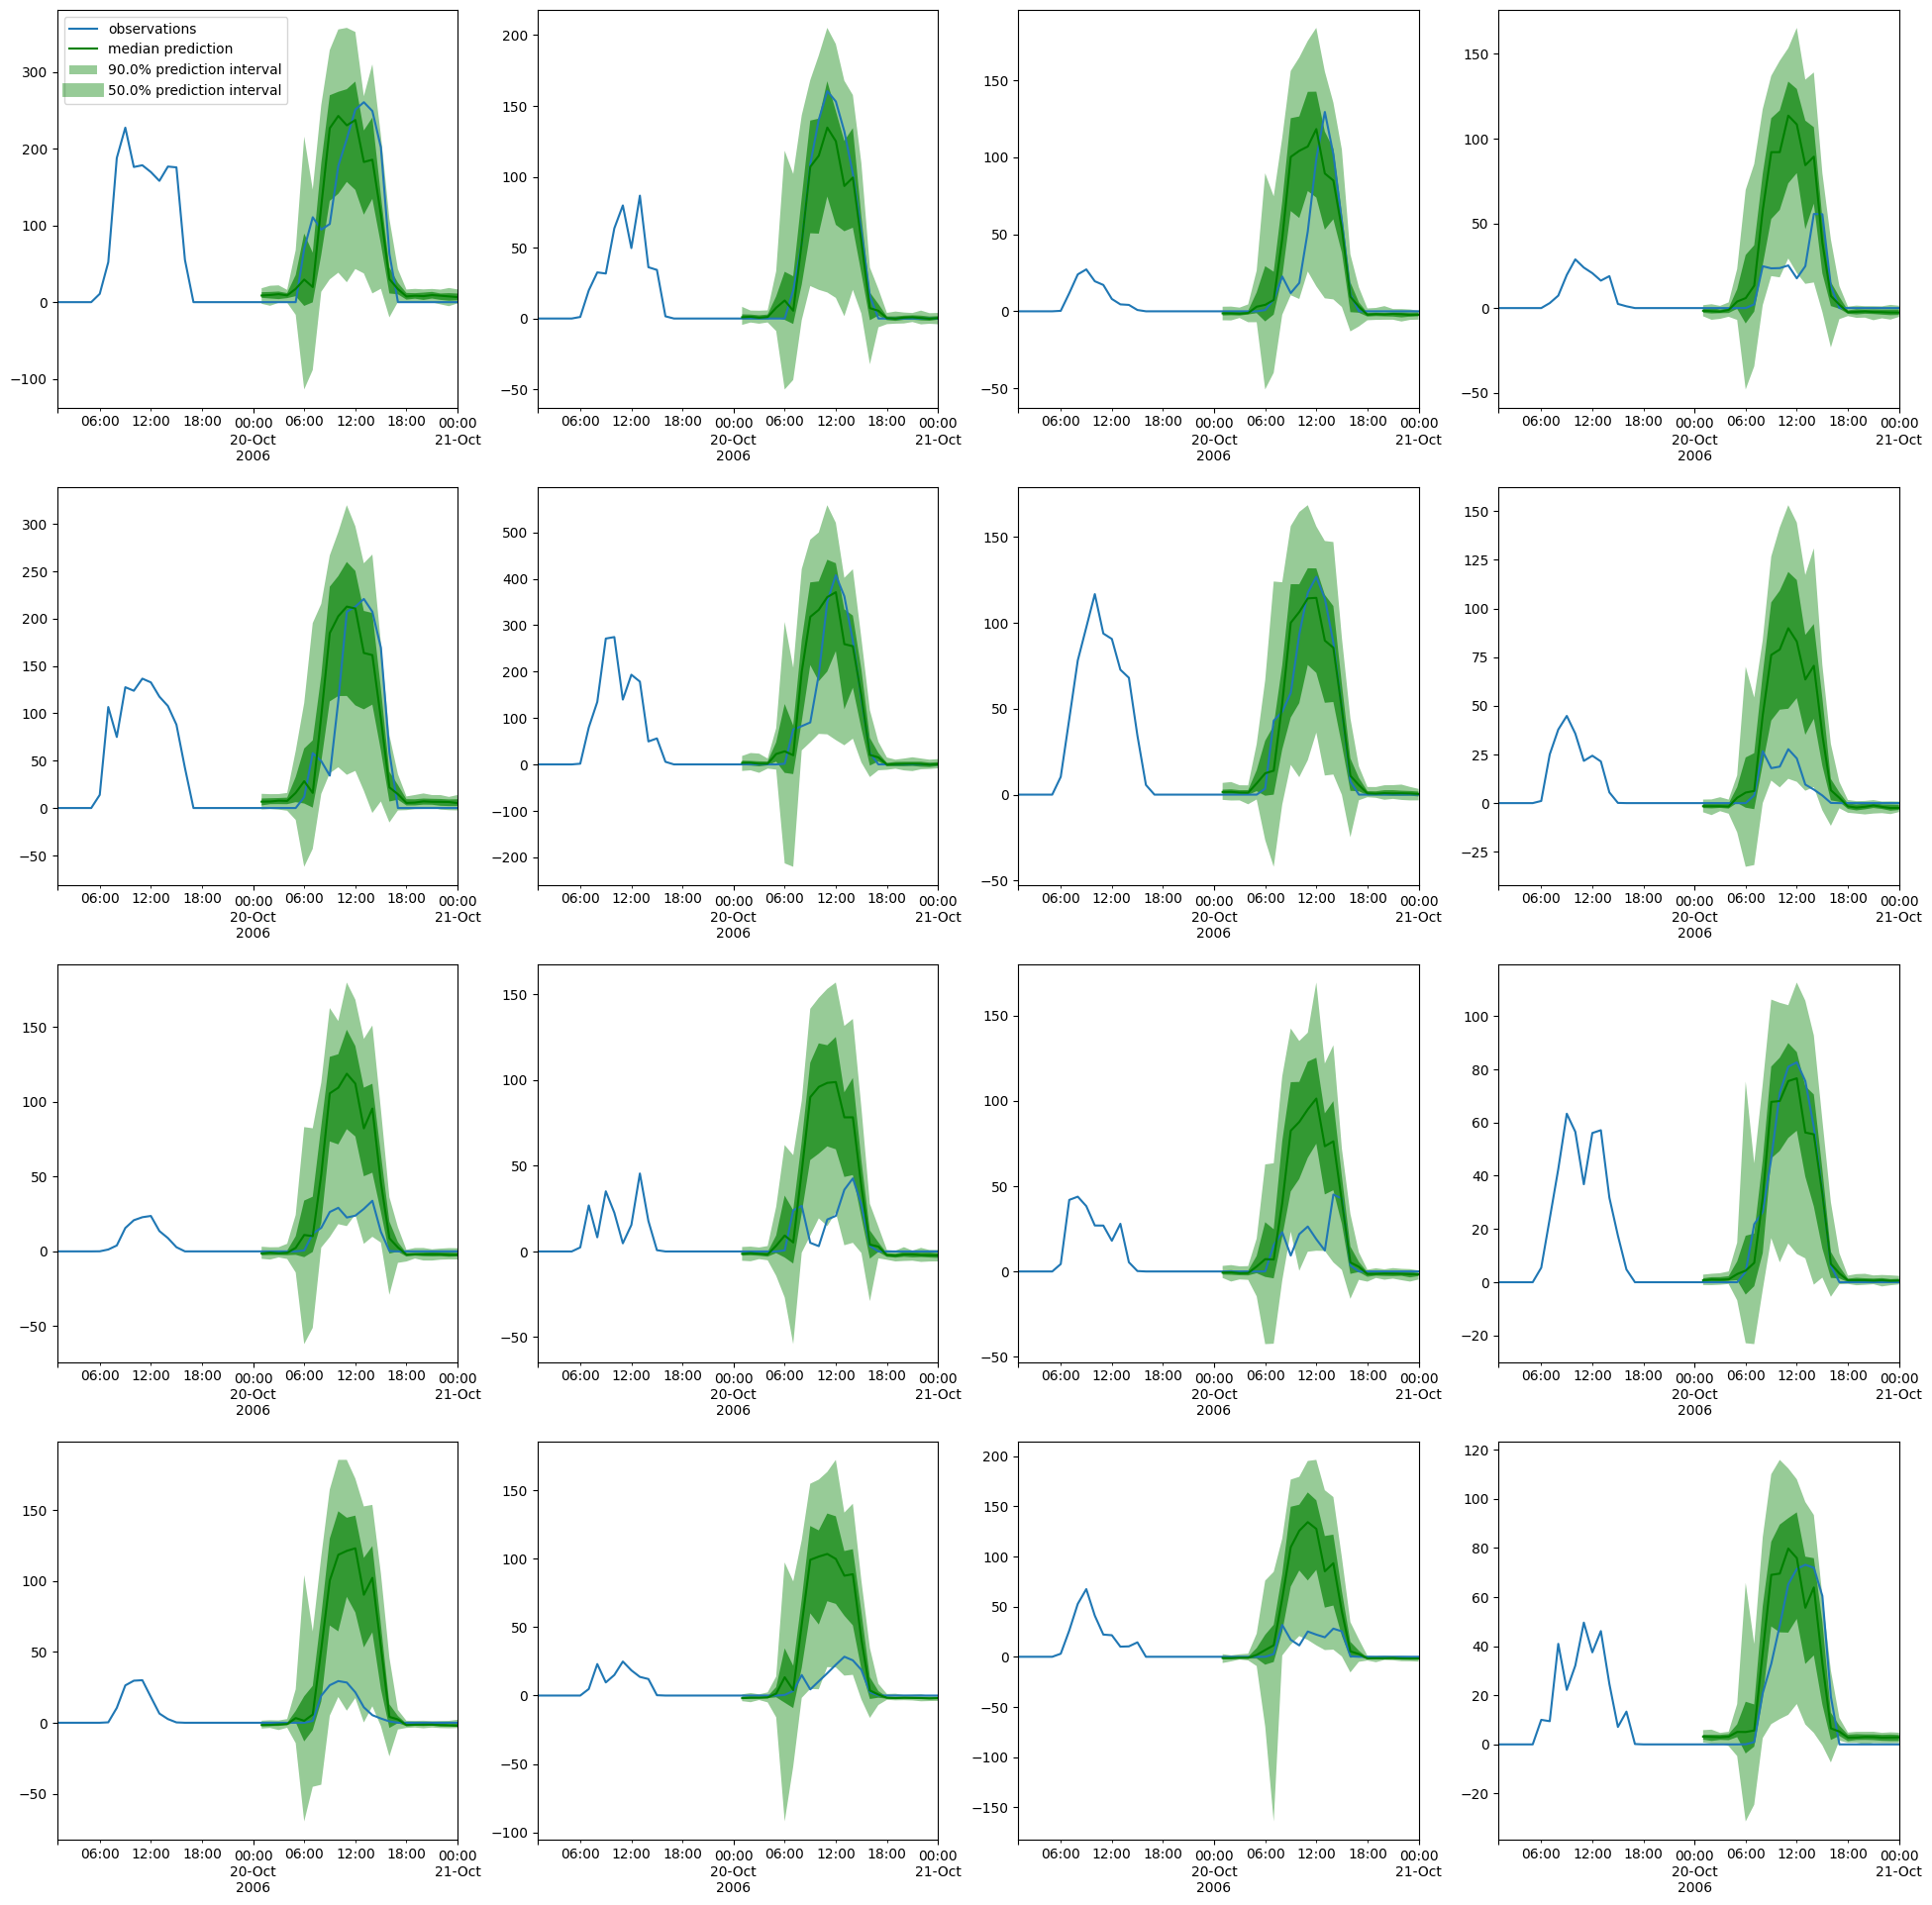

In [16]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()